## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/training/"

print("Collecting file paths...")
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths, fixed_paths = [], []
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

print("Collecting file contents...")
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

5623it [00:00, 56224.96it/s]

21757it [00:00, 67241.36it/s]
 26%|██▋       | 5762/21756 [00:00<00:00, 57578.60it/s]

100%|██████████| 21756/21756 [00:00<00:00, 58569.99it/s]

Number of processed files:-
21756 buggy files + 21756 fixed files =  43512 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 116138.18it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 30865.63it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4726 code pairs have been removed
Current # data points: 17030


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3857 code pairs have been removed
Current # data points: 13173


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

13173it [00:03, 3856.65it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 13173/13173 [00:00<00:00, 68567.86it/s]

322 code pairs have been removed
Current # data points: 12851


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12851/12851 [00:00<00:00, 76107.39it/s]

7102 code pairs have been removed
Current # data points: 5749


#### Shuffle and keep only 1000 data points

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
final_diffs = shuf_diffs[:1000]
train_diffs, test_diffs = final_diffs[:900], final_diffs[900:]

buggy_data = [x[0] for x in train_diffs]
fixed_data = [x[1] for x in train_diffs]

test_buggy_data = [x[0] for x in test_diffs]
test_fixed_data = [x[1] for x in test_diffs]


# with open('buggy_data.txt', "w", encoding='utf-8') as file:
#     for bug in buggy_data:
#         file.write(bug+'\n')
# with open('fixed_data.txt', "w", encoding='utf-8') as file:
#     for fix in fixed_data:
#         file.write(fix+'\n')
# print('Dataset has been written to disk')

# The Experiment

In [10]:
# with open('buggy_data.txt', 'r', encoding='utf-8') as f:
#     buggy_data = f.read().split("\n")
# with open('fixed_data.txt', 'r', encoding='utf-8') as f:
#     fixed_data = f.read().split("\n")
# buggy_data = buggy_data[:-1]
# fixed_data = fixed_data[:-1]

buggy_codes = [x.split() for x in buggy_data]
fixed_codes = [['<soc>']+x.split()+['<eoc>'] for x in fixed_data]

test_buggy_codes = [x.split() for x in test_buggy_data]
test_fixed_codes = [['<soc>']+x.split()+['<eoc>'] for x in test_fixed_data]

In [11]:
print("Before vectorisation:-")
print(buggy_data[2])
print(fixed_data[2])
print("====================")
print("After vectorisation:-")
print(buggy_codes[2])
print(fixed_codes[2])

Before vectorisation:-
return Class.forName(className);
return JavaUtils.loadClass(className);
After vectorisation:-
['return', 'Class.forName(className);']
['<soc>', 'return', 'JavaUtils.loadClass(className);', '<eoc>']


In [12]:
vocab = set([x for y in buggy_codes for x in y]+[x for y in fixed_codes for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [13]:
print(int_token_map)

{1: 'getUserCodeClassLoader());', 2: 'TestUtil.ramCopyOf(dir));', 3: 'writer.getReader(applyAllDeletes);', 4: 'this(firstName,', 5: 'getOrCreateCollectionWrapper();', 6: 'operator.isOptimisable(expr,', 7: '"Left(1.0)\\nRight(2.0,2.0,2.0)";', 8: 'familyMap', 9: '(in.getCurrentToken().isNumeric())', 10: 'includedColumns.length', 11: 'List<CmsResource>', 12: 'int[]{2});', 13: 'initIndex();', 14: 'mo.initialize(jc,', 15: 'memoryMode', 16: 'CmsContainerElementBean(OpenCms.getADEManager().convertToServerId(id),', 17: 'JavaUtils.loadClass(className);', 18: 'super(size);', 19: 'dirs[k]', 20: 'currentPartitionSize', 21: 'File("work");', 22: 'EdgePath.create(Direction.IN', 23: 'analyzeExpr((ExprNodeGenericFuncDesc)', 24: 'Please', 25: 'schColl', 26: 'fileName.substring(0,', 27: 'exchange.getContext().getTypeConverter().mandatoryConvertTo(InputStream.class,', 28: 'list.add(PrinterMode.ZIP_FILE_BIN.name());', 29: 'MockTokenFilter.ENGLISH_STOPSET,', 30: '"groupby2.q"};', 31: '(configurationDirector

In [14]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in buggy_codes])
max_fixed_len = max([len(txt) for txt in fixed_codes])
num_dps = len(fixed_codes)
num_test_dps = len(test_fixed_codes)

# test_buggy_codes = [x for x in test_buggy_codes if len(x) <= max_buggy_len]
# test_fixed_codes = [x for x in test_fixed_codes if len(x) <= max_fixed_len]

In [15]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 900
Vocabulary size: 3364
Max length in buggy codes: 33
Max length in fixed codes: 43


In [16]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(buggy_codes, fixed_codes)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.


test_buggy_inputs =  np.zeros((num_test_dps, max_buggy_len), dtype='int32')
test_fixed_inputs =  np.zeros((num_test_dps, max_fixed_len), dtype='int32')

for i, (buggy, fixed) in enumerate(zip(test_buggy_codes, test_fixed_codes)):
    for t, token in enumerate(buggy):
        if token not in list(token_int_map.keys()):
            test_buggy_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        if token not in list(token_int_map.keys()):
            test_fixed_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_fixed_inputs[i, t] = token_int_map[token]

In [17]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W1015 10:32:37.926249 140464068876032 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 10:32:37.935966 140464068876032 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 10:32:37.940004 140464068876032 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 10:32:38.871936 140464068876032 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 43)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 43, 3364)     29221156    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 43)           0           model_2[1][0]                    
__________

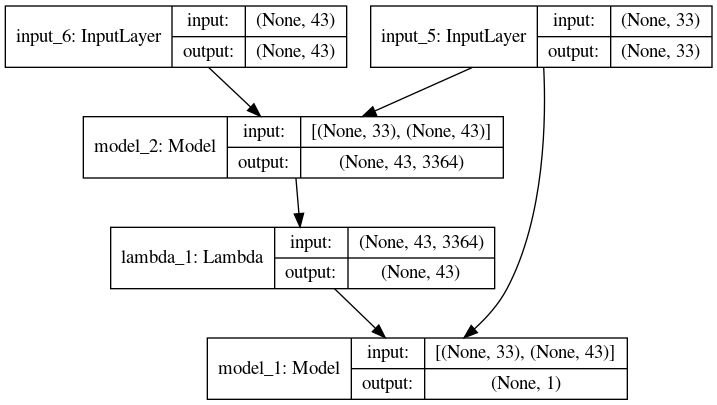

In [18]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_apr.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_apr.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_apr.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_apr.png')

In [19]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<soc>"]
    for buggy, generated in tqdm(zip(bugs, gntd_ints), total=len(bugs)):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eoc>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints


def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

In [20]:
import datetime
from tqdm import tqdm


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in range(epochs):
    print('Iteration', str(e+1)+'/'+str(epochs)+':-')
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
    generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    generated_codes = decode_ints(generated_ints, int_token_map)
    for buggy, fixed, gnrtd in zip(test_buggy_codes, test_fixed_codes, generated_codes):
        print('Buggy code:', ' '.join(buggy))
        print('---')
        print('Fixed code:', ' '.join(fixed[1:-1]))
        print('Genration: ', ' '.join(gnrtd[1:]))
        print('=============')
        print('=============')
end_time = datetime.datetime.now().replace(microsecond=0)

Iteration 1/30:-


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
900/900 [==============================] - 7s 8ms/step - loss: 0.0320 - acc: 0.9922


100%|██████████| 900/900 [21:59<00:00,  1.47s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 7.9712 - acc: 0.0000e+00


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


900/900 [==============================] - 4s 4ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 605.8377 - model_1_loss: 0.0127 - model_2_loss: 6.0582


100%|██████████| 100/100 [00:12<00:00,  8.99it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  return
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if if {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  = = new new
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  return
Buggy code: count += info.docCount - info.getDelCount();
---
Fixed code: count += info.docCount - numDeletedDocs(info);
Genration:  return retur


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


900/900 [==============================] - 4s 4ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [02:07<00:00,  6.08it/s]


Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 1.2762 - acc: 0.7544
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 472.2528 - model_1_loss: 7.5250 - model_2_loss: 4.6473


100%|██████████| 100/100 [00:24<00:00,  7.13it/s]


Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return new HashMap<>());
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  return new HashMap<>());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (input {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String String = new HashMap<>());
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  return new HashMap<>());
Buggy code: count += info.docCount - info.getDelCount();
---
Fix

900/900 [==============================] - 4s 4ms/step - loss: 0.8249 - acc: 0.6878


100%|██████████| 900/900 [03:53<00:00,  2.89it/s]


Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.1714 - acc: 0.8678
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 411.7581 - model_1_loss: 7.6899 - model_2_loss: 4.0407


100%|██████████| 100/100 [00:42<00:00,  1.53it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return new HashMap<>());
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  return new HashMap<>());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (input {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  final final final final final final final final String String String String this.createChildProcessor(routeContext,
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  return 

900/900 [==============================] - 4s 4ms/step - loss: 0.4475 - acc: 0.8656


100%|██████████| 900/900 [07:25<00:00,  1.84it/s]


Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.0728 - acc: 0.9500
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 365.1621 - model_1_loss: 0.2985 - model_2_loss: 3.6486


100%|██████████| 100/100 [00:19<00:00,  7.33it/s]


Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return new HashMap<>());
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  super(size);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  } {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String key
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  return new HashMap<>());
Buggy code: count += info.docCount - info.getDelCount();
---
Fixed code: count += info.docCount - numDelete

900/900 [==============================] - 3s 4ms/step - loss: 0.0079 - acc: 1.0000


100%|██████████| 900/900 [04:11<00:00,  5.42it/s]


Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.0338 - acc: 0.9800
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 332.2996 - model_1_loss: 0.1265 - model_2_loss: 3.3217


100%|██████████| 100/100 [00:19<00:00,  4.37it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  throw new HashMap<String, {}
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  fileName.append(componentPackage.replaceAll("\\.",
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (input {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String String String indexTable = QuartzHelper.getQuartzContextName(getCamelContext());
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  throw

900/900 [==============================] - 4s 4ms/step - loss: 3.9099e-04 - acc: 1.0000


100%|██████████| 900/900 [03:45<00:00,  4.51it/s]


Epoch 1/1
900/900 [==============================] - 3s 4ms/step - loss: 0.0111 - acc: 0.9956
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 302.8279 - model_1_loss: 0.1389 - model_2_loss: 3.0269


100%|██████████| 100/100 [00:22<00:00,  3.28it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return (myTokenType == null ? : o.hashCode());
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  assertEquals(clusterId, class=\""+self.getZclass()+"-cnt\"")
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  } else else else else < 0) < 0) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String String lambda = QuartzHelper.getQuartzContextName(getCamelContext());
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoa

900/900 [==============================] - 4s 4ms/step - loss: 5.3001e-04 - acc: 1.0000


100%|██████████| 900/900 [03:52<00:00,  3.82it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0076 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 0.0036 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 275.9024 - model_1_loss: 0.1000 - model_2_loss: 2.7580


100%|██████████| 100/100 [00:30<00:00,  2.81it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  throw notSupportedOnClient();
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  .setDescription("Manage = AccessType.OperateEntry)
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (caller.getType() == null && null && input.get(0) == input.get(0) == null) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String aggName = true);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  

900/900 [==============================] - 4s 4ms/step - loss: 5.2936e-04 - acc: 1.0000


100%|██████████| 900/900 [05:14<00:00,  2.14it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0023 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 0.0030 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 246.0206 - model_1_loss: 0.0950 - model_2_loss: 2.4593


100%|██████████| 100/100 [00:16<00:00,  5.88it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  super(size);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  addCommandLineOptions(commandLine, context, stsProperties, compilerSettings, true);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (mro.isSampler() && null) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String aggName = (float)(stats.getTotalTermFreq()+1)
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  supe

900/900 [==============================] - 4s 4ms/step - loss: 3.9861e-04 - acc: 1.0000


100%|██████████| 900/900 [03:19<00:00,  4.36it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 9.9303e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 0.0016 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 223.2451 - model_1_loss: 0.0884 - model_2_loss: 2.2316


100%|██████████| 100/100 [00:17<00:00,  3.80it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  cctx.deploy().unwind(cctx);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  (OStorageLocalAbstract) ODatabaseRecordThreadLocal.INSTANCE.get().getStorage().getUnderlying());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (conf.getBoolean(MemStoreLAB.USEMSLAB_KEY, MemStoreLAB.USEMSLAB_DEFAULT)) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  private final final final EOBJECT_LOOKUP_CACHE_KEY SERVERNAME_PATTERN = DefaultReferenceDescription.

900/900 [==============================] - 3s 4ms/step - loss: 3.0427e-04 - acc: 1.0000


100%|██████████| 900/900 [03:32<00:00,  2.41it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0048 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 0.0017 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 195.9053 - model_1_loss: 0.0545 - model_2_loss: 1.9585


100%|██████████| 100/100 [00:20<00:00,  3.51it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return new VcsLogPanel(this, myUi);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.hiveConf, true);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (conf.getBoolean(MemStoreLAB.USEMSLAB_KEY, MemStoreLAB.USEMSLAB_DEFAULT)) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String tabIdName = getUnescapedName(tableTree).toLowerCase();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths)

900/900 [==============================] - 4s 4ms/step - loss: 2.3893e-04 - acc: 1.0000


100%|██████████| 900/900 [03:59<00:00,  4.66it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 6.6799e-04 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 0.0016 - acc: 0.9989
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 171.7309 - model_1_loss: 0.0574 - model_2_loss: 1.7167


100%|██████████| 100/100 [00:21<00:00,  1.78it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  return channel.finishConnect();
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  mo.initialize(jc,
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String path = uri.getRawPath();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  return channel.finishConnect();
Buggy code: cou

900/900 [==============================] - 4s 4ms/step - loss: 1.9814e-04 - acc: 1.0000


100%|██████████| 900/900 [03:38<00:00,  4.89it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0064 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 0.0012 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 150.3719 - model_1_loss: 0.0602 - model_2_loss: 1.5031


100%|██████████| 100/100 [00:21<00:00,  3.99it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  commandLine.addArgument(componentGroup);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  Min, context, Sum, Avg
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  Table source = rp.getSchemaEvolution();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  commandLine.addArgument(c

900/900 [==============================] - 4s 4ms/step - loss: 1.7262e-04 - acc: 1.0000


100%|██████████| 900/900 [03:28<00:00,  4.73it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 4.0861e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 7.4198e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 131.2065 - model_1_loss: 0.0328 - model_2_loss: 1.3117


100%|██████████| 100/100 [00:17<00:00,  3.71it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  updateIndexes(put, lockId);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  addFamilyMapToWALEdit(put.getFamilyCellMap(), walEdit);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (conf.getBoolean(MemStoreLAB.USEMSLAB_KEY, MemStoreLAB.USEMSLAB_DEFAULT)) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String path = uri.getRawPath();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Ge

900/900 [==============================] - 3s 4ms/step - loss: 1.4494e-04 - acc: 1.0000


100%|██████████| 900/900 [03:24<00:00,  4.76it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 3.2978e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 9.3232e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 110.5190 - model_1_loss: 0.0359 - model_2_loss: 1.1048


100%|██████████| 100/100 [00:20<00:00,  1.77it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  reordereNodeConds.add(nodeConds.get(tgtToNodeExprMap[k]));
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  hConfFile, cConfFile, eventHandler));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (file.getPath().startsWith(endpointNormalized == null || !monitor.isCanceled()) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String tabIdName = getUnescapedName(tableTree).toLowerCase();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed co

900/900 [==============================] - 4s 4ms/step - loss: 1.2620e-04 - acc: 1.0000


100%|██████████| 900/900 [03:21<00:00,  5.32it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 4.0015e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 5.3935e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 94.1441 - model_1_loss: 0.0190 - model_2_loss: 0.9413


100%|██████████| 100/100 [00:19<00:00,  3.62it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  this.setOwner(user);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  timestampWritable.write(new DataOutputStream(output));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (conf.getBoolean(MemStoreLAB.USEMSLAB_KEY, MemStoreLAB.USEMSLAB_DEFAULT)) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.b

900/900 [==============================] - 4s 4ms/step - loss: 1.0909e-04 - acc: 1.0000


100%|██████████| 900/900 [03:23<00:00,  4.54it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0012 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 6.0112e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 77.0261 - model_1_loss: 0.0371 - model_2_loss: 0.7699


100%|██████████| 100/100 [00:18<00:00,  3.74it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  syncDLObjects, companyId, repositoryId);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (smallfloat <= (63-2)<<5) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String macAddress = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(fami

900/900 [==============================] - 4s 4ms/step - loss: 9.4606e-05 - acc: 1.0000


100%|██████████| 900/900 [03:11<00:00,  4.69it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 4.7148e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 4.9184e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 65.7783 - model_1_loss: 0.0376 - model_2_loss: 0.6574


100%|██████████| 100/100 [00:18<00:00,  3.54it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.columnAccessInfo.add(tab.getCompleteName(), tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String path = uri.getRawPath();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code

900/900 [==============================] - 4s 4ms/step - loss: 8.2970e-05 - acc: 1.0000


100%|██████████| 900/900 [03:16<00:00,  4.56it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 2.0087e-04 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 3.9968e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 51.7988 - model_1_loss: 0.0197 - model_2_loss: 0.5178


100%|██████████| 100/100 [00:16<00:00,  3.53it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  reordereNodeConds.add(nodeConds.get(tgtToNodeExprMap[k]));
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.columnAccessInfo.add(tab.getCompleteName(), tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (smallfloat <= (63-2)<<5) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String path = uri.getRawPath();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(

900/900 [==============================] - 3s 4ms/step - loss: 7.3589e-05 - acc: 1.0000


100%|██████████| 900/900 [03:12<00:00,  4.80it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 3.6092e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 42.8353 - model_1_loss: 0.0286 - model_2_loss: 0.4281


100%|██████████| 100/100 [00:16<00:00,  3.64it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  FieldCache.DEFAULT.purgeByCacheKey(slowR.getCoreCacheKey());
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.columnAccessInfo.add(tab.getCompleteName(), tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadH

900/900 [==============================] - 4s 4ms/step - loss: 6.5725e-05 - acc: 1.0000


100%|██████████| 900/900 [03:13<00:00,  4.09it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 1.2696e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 2.9429e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 35.8232 - model_1_loss: 0.0299 - model_2_loss: 0.3579


100%|██████████| 100/100 [00:15<00:00,  3.72it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  timestampWritable.write(new DataOutputStream(output));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed 

900/900 [==============================] - 4s 4ms/step - loss: 5.8681e-05 - acc: 1.0000


100%|██████████| 900/900 [03:24<00:00,  4.91it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 2.5802e-04 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 2.6071e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 30.0986 - model_1_loss: 0.0299 - model_2_loss: 0.3007


100%|██████████| 100/100 [00:15<00:00,  3.64it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  timestampWritable.write(new DataOutputStream(output));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (!this.comparators1[i].equalToReference(candidate.getFieldNotNull(keyFields2[i]))) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoa

900/900 [==============================] - 4s 4ms/step - loss: 5.2849e-05 - acc: 1.0000


100%|██████████| 900/900 [03:18<00:00,  4.59it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 1.9280e-04 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 2.3343e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 25.5525 - model_1_loss: 0.0302 - model_2_loss: 0.2552


100%|██████████| 100/100 [00:16<00:00,  4.00it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  syncDLObjects, companyId, repositoryId);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (smallfloat <= (63-2)<<5) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String path = uri.getRawPath();
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  "/jobs/:%s/verti

900/900 [==============================] - 4s 4ms/step - loss: 4.7884e-05 - acc: 1.0000


100%|██████████| 900/900 [03:15<00:00,  4.79it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 9.2405e-05 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 2.0458e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 20.7374 - model_1_loss: 0.0205 - model_2_loss: 0.2072


100%|██████████| 100/100 [00:17<00:00,  3.65it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  syncDLObjects, companyId, repositoryId);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (smallfloat instanceof (63-2)<<5) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFi

900/900 [==============================] - 4s 4ms/step - loss: 4.3603e-05 - acc: 1.0000


100%|██████████| 900/900 [03:12<00:00,  4.60it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 1.0455e-04 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 1.6963e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 17.0066 - model_1_loss: 0.0212 - model_2_loss: 0.1699


100%|██████████| 100/100 [00:16<00:00,  3.66it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.columnAccessInfo.add(tab.getCompleteName(), tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkL

900/900 [==============================] - 4s 4ms/step - loss: 3.9631e-05 - acc: 1.0000


100%|██████████| 900/900 [03:13<00:00,  4.63it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 2.2552e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 1.5557e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 14.4437 - model_1_loss: 0.0205 - model_2_loss: 0.1442


100%|██████████| 100/100 [00:16<00:00,  5.04it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  this.columnAccessInfo.add(tab.getCompleteName(), tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (smallfloat instanceof (63-2)<<5) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyP

900/900 [==============================] - 4s 4ms/step - loss: 3.6238e-05 - acc: 1.0000


100%|██████████| 900/900 [03:12<00:00,  4.67it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 7.3432e-05 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 1.4010e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 12.7137 - model_1_loss: 0.0206 - model_2_loss: 0.1269


100%|██████████| 100/100 [00:16<00:00,  3.60it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  wh.write(self.getLabelAttrs()).write(" tab.getAllCols().get(ord.i).getName());
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(

900/900 [==============================] - 4s 4ms/step - loss: 3.3122e-05 - acc: 1.0000


100%|██████████| 900/900 [03:11<00:00,  4.58it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 6.8921e-05 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 1.2676e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 10.4736 - model_1_loss: 0.0216 - model_2_loss: 0.1045


100%|██████████| 100/100 [00:17<00:00,  3.12it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  timestampWritable.write(new DataOutputStream(output));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed 

900/900 [==============================] - 4s 4ms/step - loss: 3.0551e-05 - acc: 1.0000


100%|██████████| 900/900 [03:16<00:00,  4.65it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 1.3191e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 1.1615e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 8.8599 - model_1_loss: 0.0209 - model_2_loss: 0.0884


100%|██████████| 100/100 [00:17<00:00,  3.63it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  elems.addRow(l);
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  syncDLObjects, companyId, repositoryId);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: return region.bulkLoadHFiles(familyPaths);
Genration:  e

900/900 [==============================] - 3s 4ms/step - loss: 2.8255e-05 - acc: 1.0000


100%|██████████| 900/900 [03:15<00:00,  4.75it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 9.2030e-05 - acc: 1.0000

900/900 [==============================] - 3s 4ms/step - loss: 1.0613e-04 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 8.1699 - model_1_loss: 0.0216 - model_2_loss: 0.0815


100%|██████████| 100/100 [00:17<00:00,  3.79it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  timestampWritable.write(new DataOutputStream(output));
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed 

900/900 [==============================] - 4s 4ms/step - loss: 2.6250e-05 - acc: 1.0000


100%|██████████| 900/900 [03:14<00:00,  4.72it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 3s - loss: 1.3418e-04 - acc: 1.0000

900/900 [==============================] - 4s 4ms/step - loss: 9.7409e-05 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 6.8436 - model_1_loss: 0.0212 - model_2_loss: 0.0682


100%|██████████| 100/100 [00:16<00:00,  3.27it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  wh.write(self.getLabelAttrs()).write(" mRPAREN);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: 

In [21]:
print("Training took (h:mm:ss)", end_time-start_time)

Training took (h:mm:ss) 2:22:11


In [22]:
generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(test_buggy_codes, test_fixed_codes, generated_codes):
    print('Buggy code:', ' '.join(buggy))
    print('---')
    print('Fixed code:', ' '.join(fixed[1:-1]))
    print('Genration: ', ' '.join(gnrtd[1:]))
    print('=============')
    print('=============')

100%|██████████| 100/100 [00:16<00:00,  3.24it/s]

Buggy code: createDataset("whom", KeyValueTable.class);
---
Fixed code: createDataset("whom", KeyValueTable.class, DatasetProperties.builder().setDescription("Store names").build());
Genration:  "/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/:%s/accumulators",
Buggy code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent);
---
Fixed code: GradleLauncher newInstance(StartParameter startParameter, ServiceRegistry parent, boolean newSession);
Genration:  wh.write(self.getLabelAttrs()).write(" mRPAREN);
Buggy code: if (this.length < newLength) {
---
Fixed code: if (this.bytes.length < newLength) {
Genration:  if (includeColumn == null || includeColumn[columnId]) {
Buggy code: String filterExpr = Utilities.serializeExpression(node);
---
Fixed code: String filterExpr = SerializationUtilities.serializeExpression(node);
Genration:  String filterExpr = SerializationUtilities.serializeExpression(node);
Buggy code: region.bulkLoadHFiles(familyPaths);
---
Fixed code: 